# Import package

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import calendar
import numpy as np
import pandas as pd
from pylab import rcParams
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf
from datetime import timedelta
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#!pip install ggplot
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns 
from ggplot import *
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 
from matplotlib.colors import ListedColormap
#!pip install plotly
import plotly
import plotly.offline as py # make offline 
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.tools as tl
import plotly.figure_factory as fig_fact
plotly.tools.set_config_file(world_readable=True, sharing='public')
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text
from sklearn.ensemble import  GradientBoostingClassifier

# Import Data

In [9]:
air_visit_df = pd.read_csv('air_visit_data.csv', parse_dates=['visit_date'])
air_reserve_df = pd.read_csv("air_reserve.csv", parse_dates=['reserve_datetime', 'visit_datetime'])
air_store =  pd.read_csv("air_store_info.csv")
holidays = pd.read_csv("date_info.csv", parse_dates=['calendar_date'])
store_ids = pd.read_csv("store_id_relation.csv")
test = pd.read_csv("sample_submission.csv")

# Dataset EDA

##  Air visit

We start with the number of visits to the air restaurants. Here we plot the total number of visitors per day over the full training time range:

In [226]:
air_visit_df.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


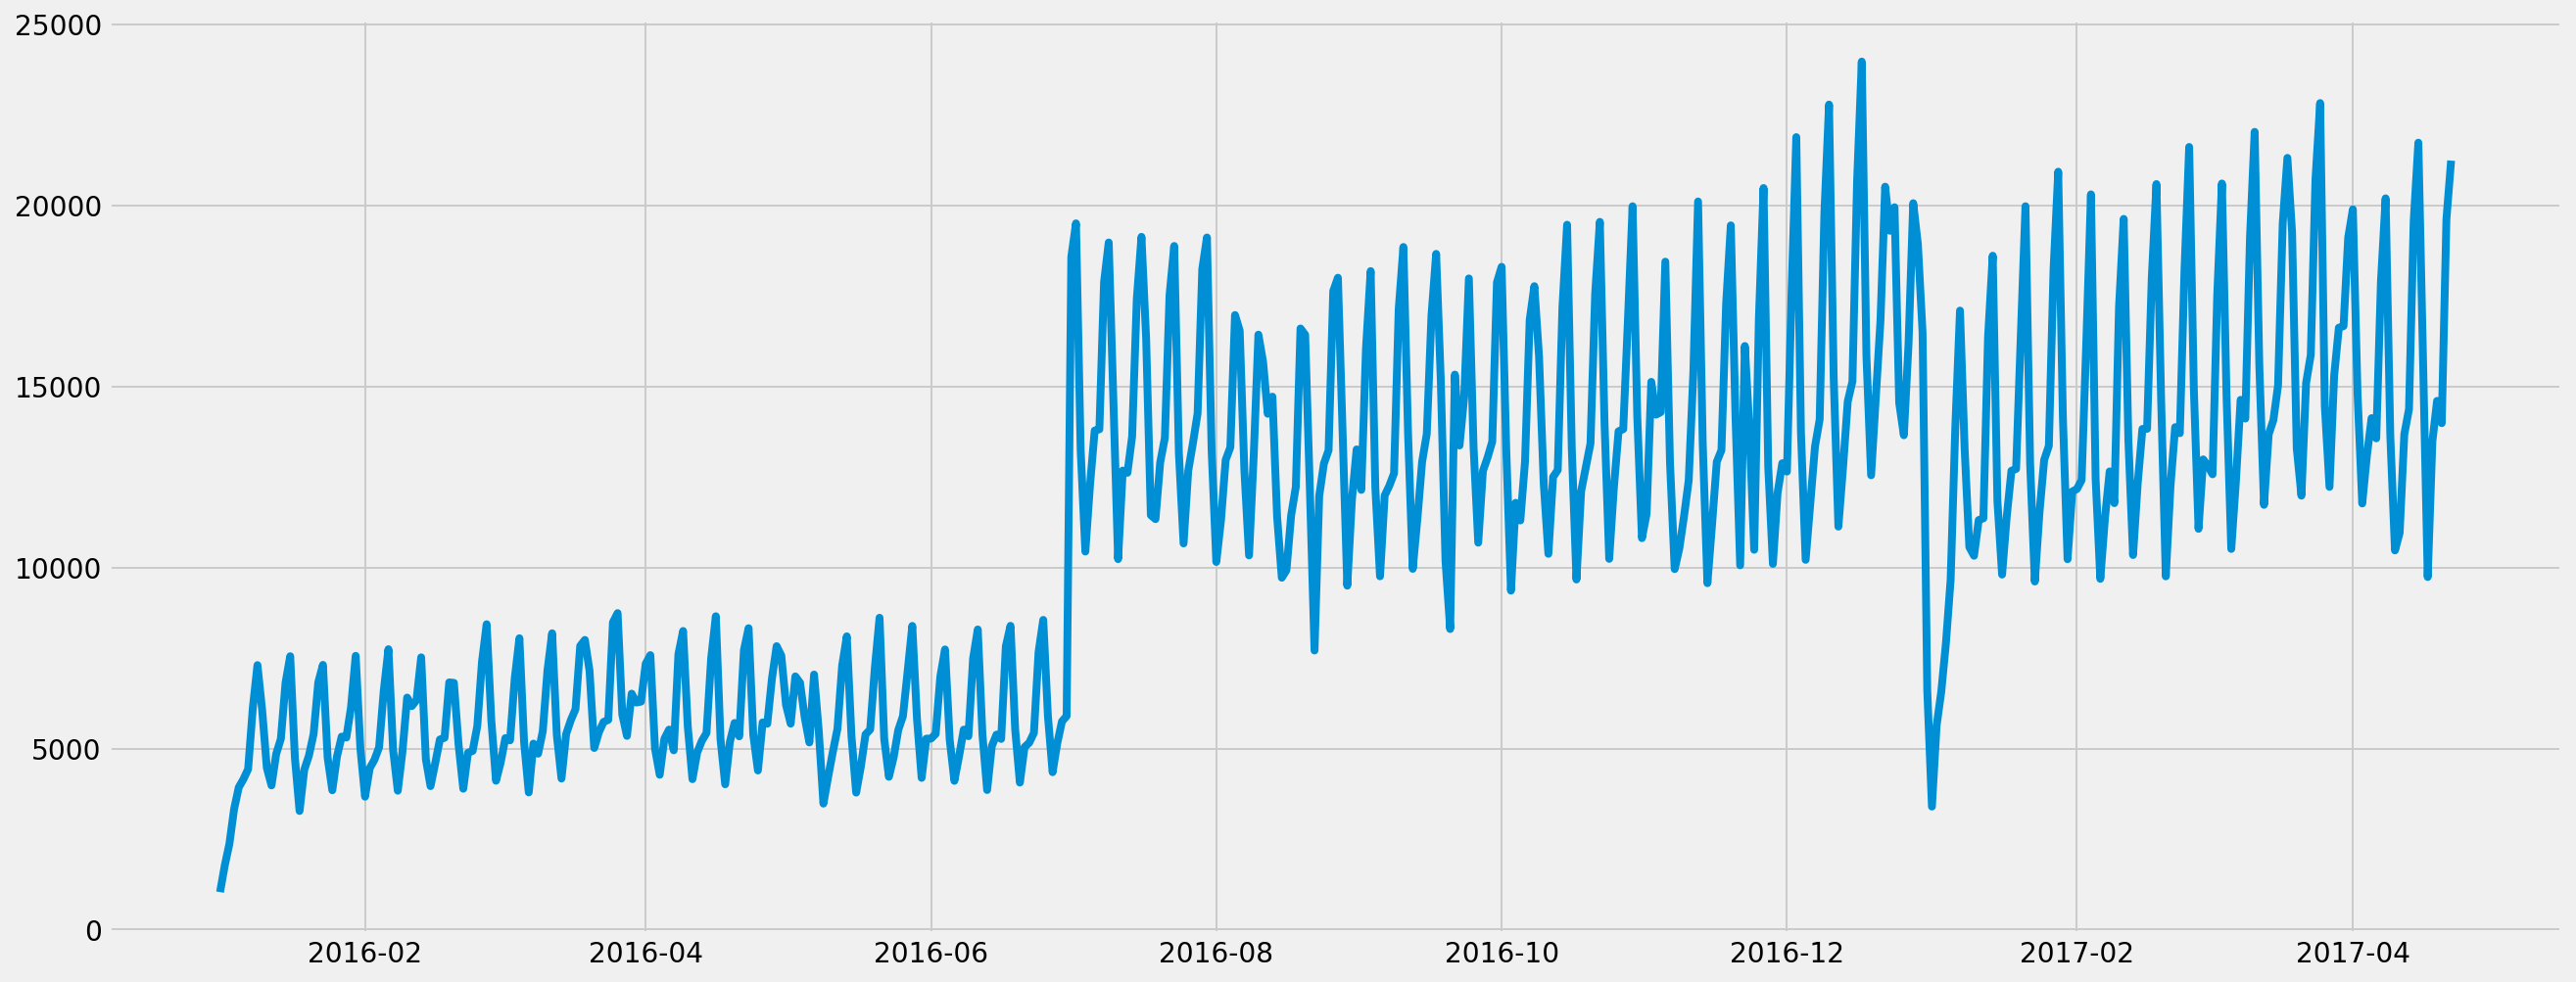

In [234]:
air_visit = air_visit_df.copy()

air_visit['Month'] = air_visit['visit_date'].dt.month
air_visit = air_visit.merge(holidays, left_on='visit_date', right_on='calendar_date', how='left')
air_visit.drop('calendar_date', axis=1, inplace=True)
a=air_visit[['visit_date','visitors']].groupby(['visit_date'], as_index=False).sum()

b=air_visit[['Month', 'visitors']].groupby(['Month'],as_index=False).mean()
#Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
#mapping = {Month: i for i, Month in enumerate(Months)}
#key = b['Month'].map(mapping)
#b = b.iloc[key.argsort()].set_index('Month').reset_index()

plt.figure(figsize = (20,8))
plt.plot(a['visit_date'], a['visitors'])

plt.show()

In [15]:
air_visit_idx = air_visit.set_index(['air_store_id', 'visit_date']); air_visit_idx.head()

visitors  Month  holiday_flg  dow
air_store_id         visit_date                                   
air_ba937bf13d40fb24 2016-01-13        25      1            0    3
                     2016-01-14        32      1            0    4
                     2016-01-15        29      1            0    5
                     2016-01-16        22      1            0    6
                     2016-01-18         6      1            0    1

## Air reserve 

In [12]:
air_reserve = air_reserve_df.copy()
air_reserve['diff_day'] = air_reserve['visit_datetime'].dt.date - air_reserve['reserve_datetime'].dt.date
air_reserve['diff_hr'] = air_reserve['visit_datetime'].dt.hour - air_reserve['reserve_datetime'].dt.hour
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].dt.date
air_reserve['visit_date'] = air_reserve['visit_datetime'].dt.date
air_reserve = air_reserve.merge(store_ids, on='air_store_id', how='left')
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,diff_day,diff_hr,reserve_date,visit_date,hpg_store_id
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,0 days,3,2016-01-01,2016-01-01,NaN
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,0 days,0,2016-01-01,2016-01-01,hpg_bcecaa70222d94e5
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,0 days,0,2016-01-01,2016-01-01,hpg_bcecaa70222d94e5
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,0 days,4,2016-01-01,2016-01-01,NaN
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,0 days,19,2016-01-01,2016-01-01,hpg_878cc70b1abc76f7


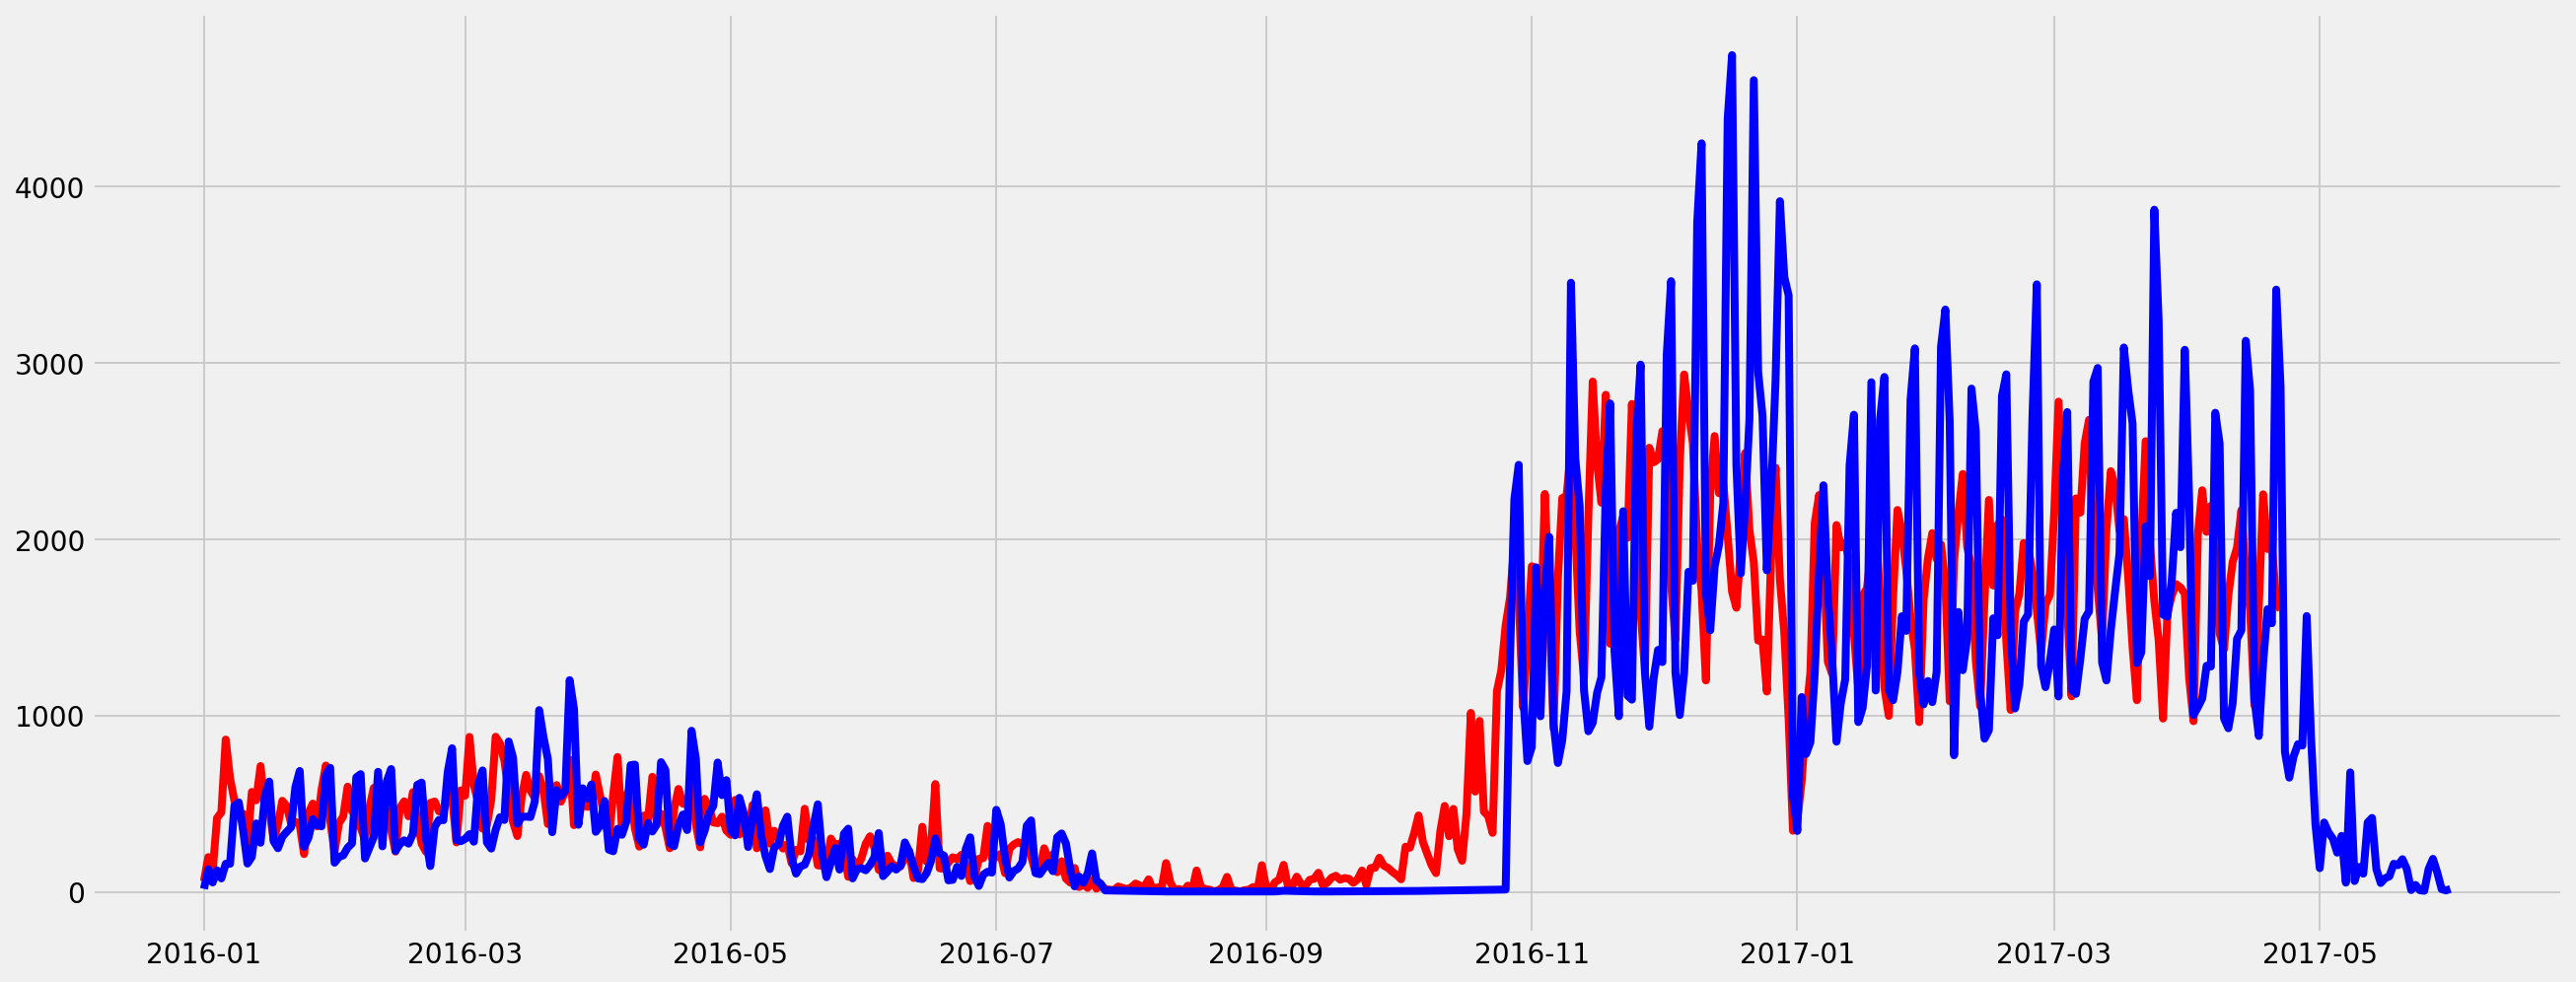

In [13]:
a1=air_reserve[['reserve_date','reserve_visitors']].groupby(['reserve_date'], as_index=False).sum()
a2=air_reserve[['visit_date','reserve_visitors']].groupby(['visit_date'], as_index=False).sum()
fig = plt.figure(figsize = (20,8))
plt.plot(a1['reserve_date'],a1['reserve_visitors'], c='red')
plt.plot(a2['visit_date'],a2['reserve_visitors'], c='blue')
plt.show()

In [14]:
air_re = air_reserve.groupby(['air_store_id','visit_date'])['reserve_visitors'].sum();air_re.head()

air_store_id          visit_date
air_00a91d42b08b08d9  2016-10-31     2
                      2016-12-05     9
                      2016-12-14    18
                      2016-12-17     2
                      2016-12-20     4
Name: reserve_visitors, dtype: int64

## Air store

In [16]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [17]:
mapbox_access_token = 'pk.eyJ1IjoiZW1tYXl1IiwiYSI6ImNqZWV3NjJ5YjFhOHEzM28yMGp2NGJmaGcifQ.thj_-iQAsFi1W5XgOft6Fg'
data = Data([
    Scattermapbox(
        lat=air_store.latitude.tolist(),
        lon=air_store.longitude.tolist(),
        mode='markers',
        # add 'bar' as a marker icon. so it's look beautiful 
        marker=Marker(
            symbol= "bar",
            size=9,
            color = "r"
        )
    )
])
layout = Layout(
    # add title
    title='Zoom to your location and find your desire restaurants',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        # add our access token
        accesstoken=mapbox_access_token,
        bearing=0,
        # add center location to our map
        center=dict(
            lat=36.2048,
            lon=138.2529
        ),
        # use style light
        style='light',
        pitch=0,
        # zoom label to 3
        zoom=3
    ),
)
# let's make the final figure
fig = dict(data=data, layout=layout)
# finally plot the map
py.iplot(fig, filename='Multiple Mapbox')

# Feature Engineering

In [25]:
!pip install xgboost

    100% |████████████████████████████████| 460kB 2.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ca/b3/02/d44d5e12c5c1eecff4a822555bac96b182551cd5e13c4795f6
Successfully built xgboost


##  Days of the week & Month of the year

In [235]:
air_visit.head()

,air_store_id,visit_date,visitors,Month,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,1,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,1,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,1,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,1,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,1,Monday,0


In [236]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mapping = {day: i for i, day in enumerate(days)}
air_visit['dow'] = air_visit['day_of_week'].map(mapping)
air_visit.drop('day_of_week', axis = 1, inplace = True)
c=air_visit.groupby(['dow'],as_index=False).agg({'visitors':np.median})

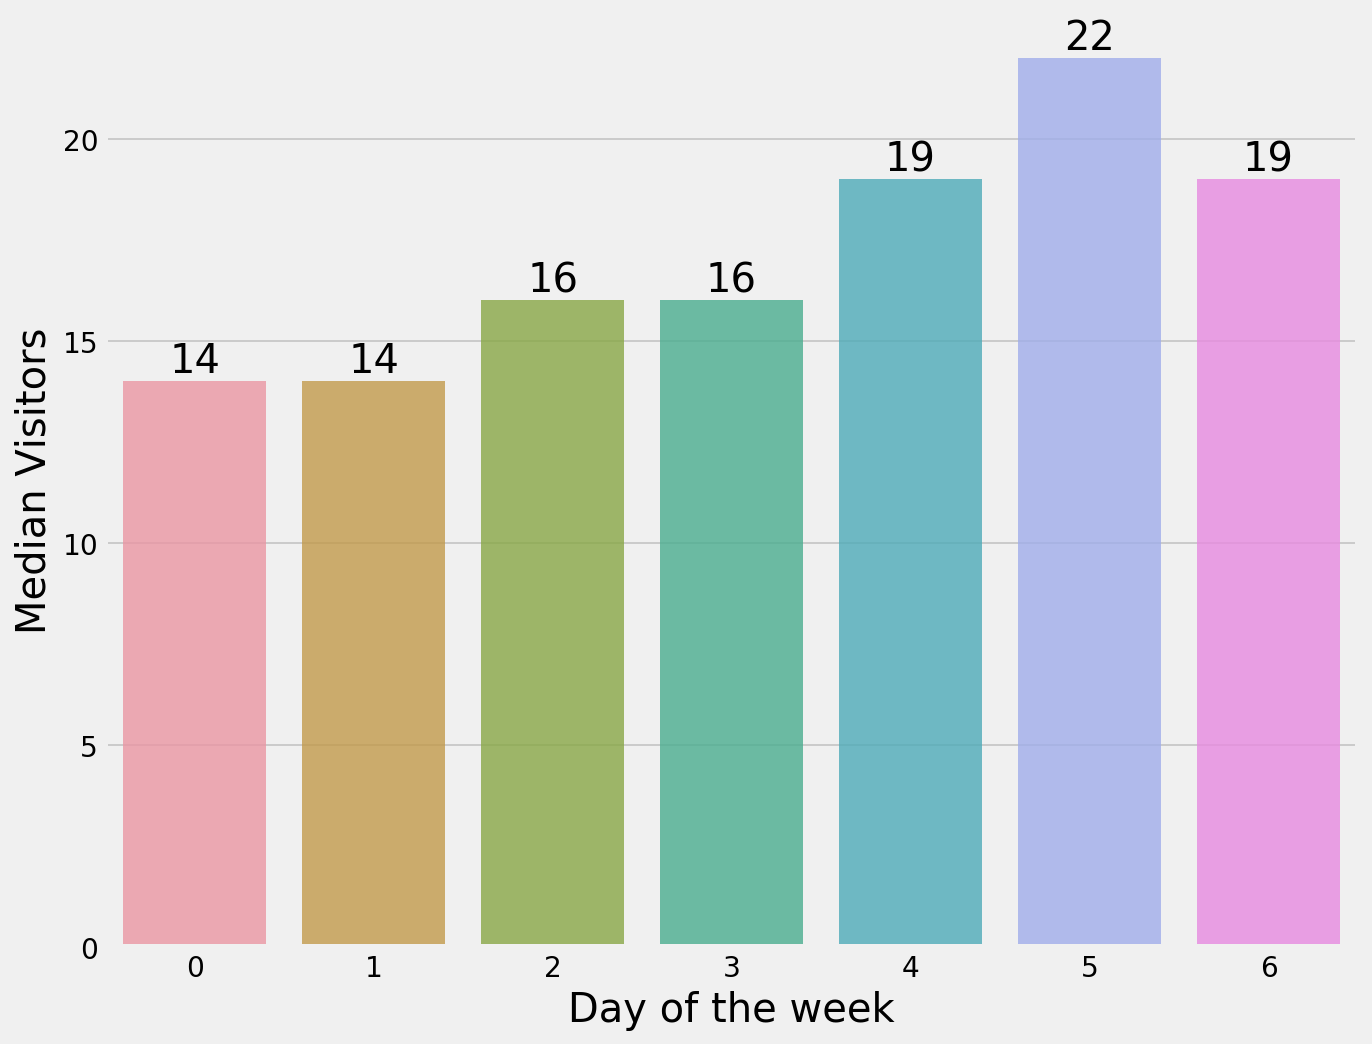

In [238]:
x = air_visit.groupby('dow')['visitors'].median()
x = x.sort_index()
#x = x.sort_values()

plt.figure(figsize=(10,8))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.ylabel('Median Visitors', fontsize = 20)
plt.xlabel('Day of the week', fontsize = 20)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize = 20)

plt.show()

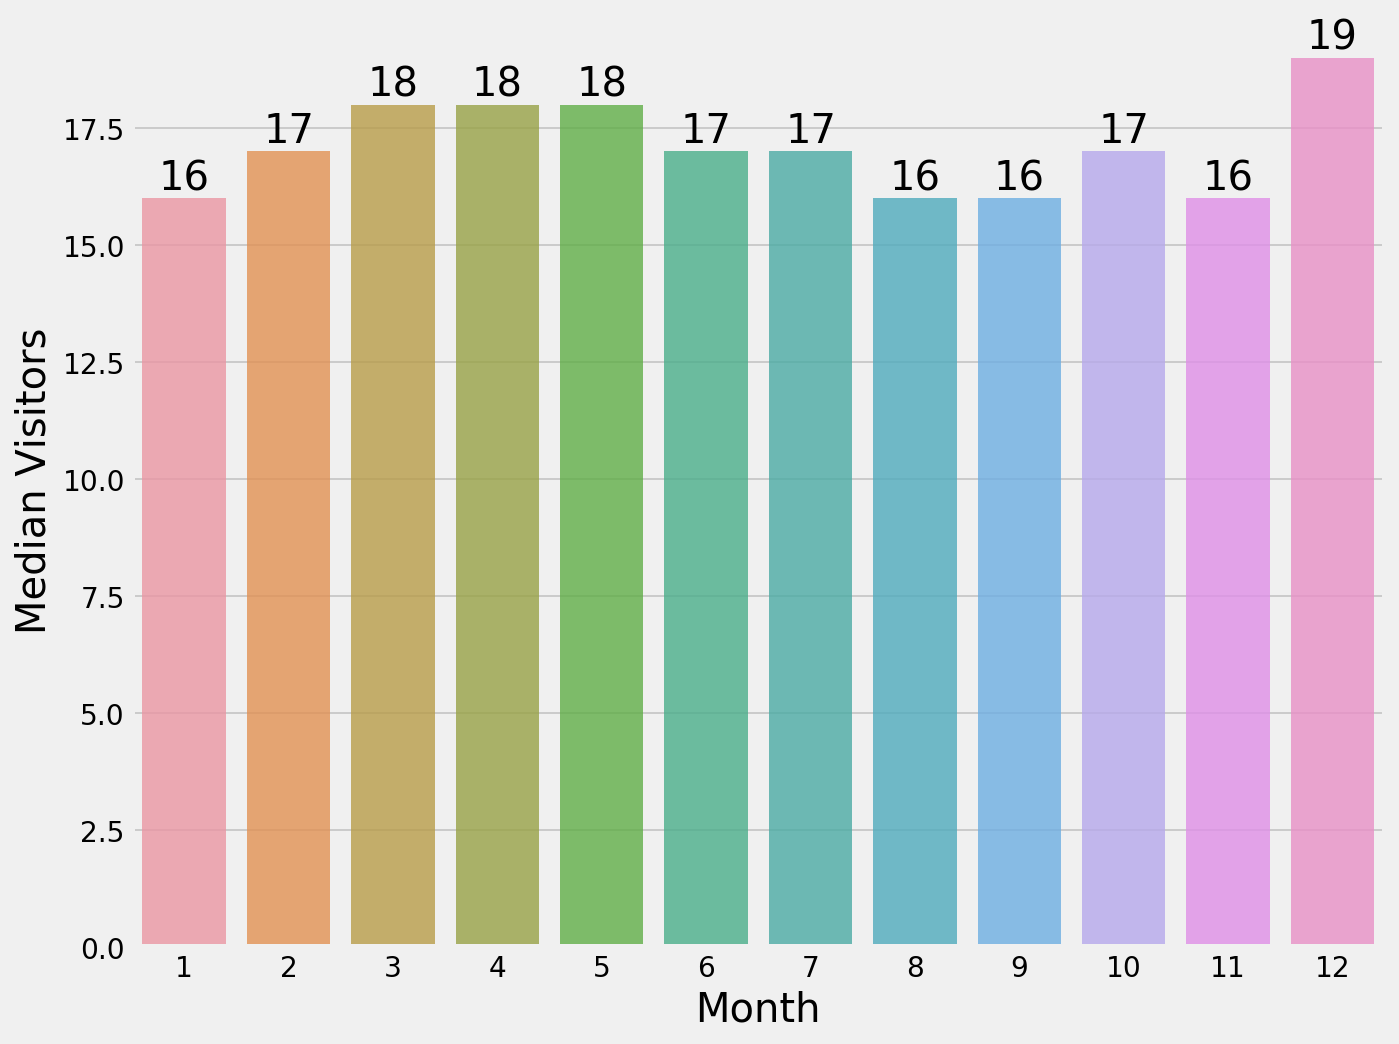

In [239]:
x = air_visit.groupby('Month')['visitors'].median()
x = x.sort_index()
#x = x.sort_values()

plt.figure(figsize=(10,8))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.ylabel('Median Visitors', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize = 20)

plt.show()

## Genre 

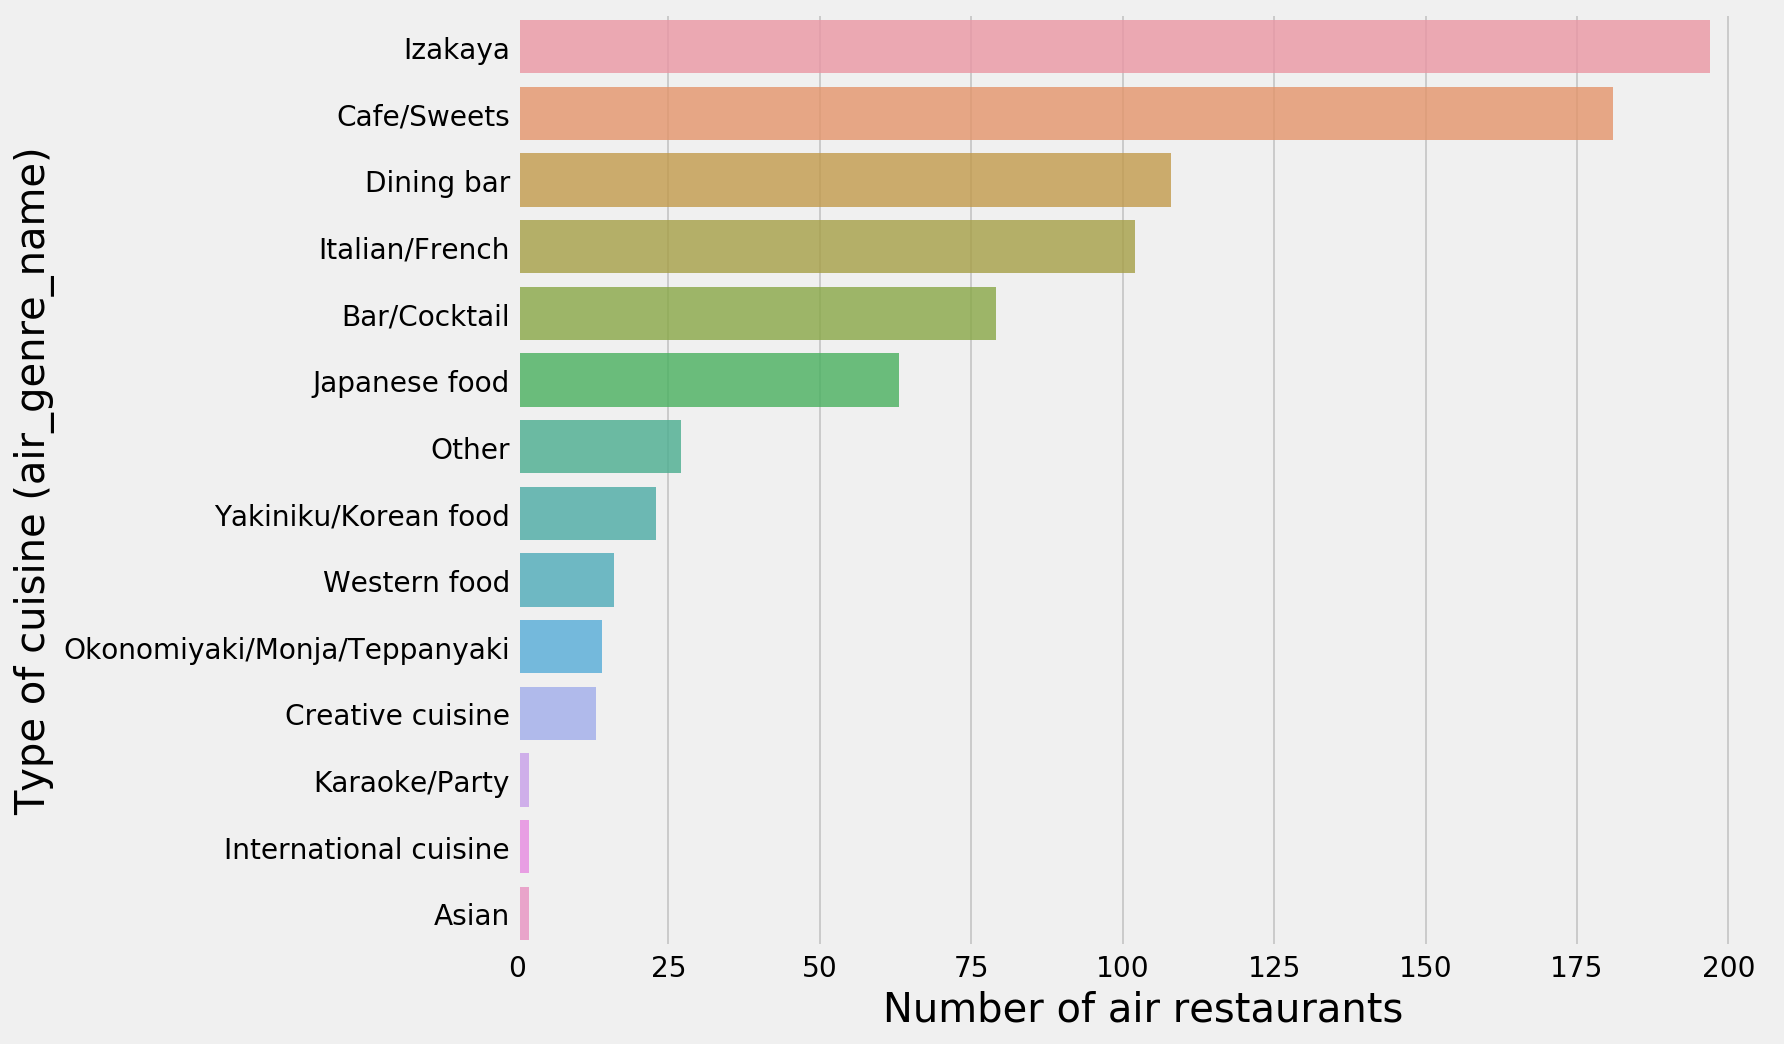

In [31]:
x = air_store.groupby('air_genre_name')['air_genre_name'].count()
x = x.sort_index()
x = x.sort_values(ascending = False)
plt.figure(figsize=(10,8))
ax = sns.barplot(x.values, x.index, alpha=0.8)
plt.ylabel('Type of cuisine (air_genre_name)', fontsize = 20)
plt.xlabel('Number of air restaurants', fontsize = 20)
plt.show()

### Genre VS Day of week

In [41]:
visit_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,visit_date,visitors,Month,holiday_flg_x,dow,holiday_flg_y
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-01,18,7,0,5,0
1,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-02,37,7,0,6,0
2,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-03,20,7,0,7,0
3,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-04,16,7,0,1,0
4,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-05,15,7,0,2,0


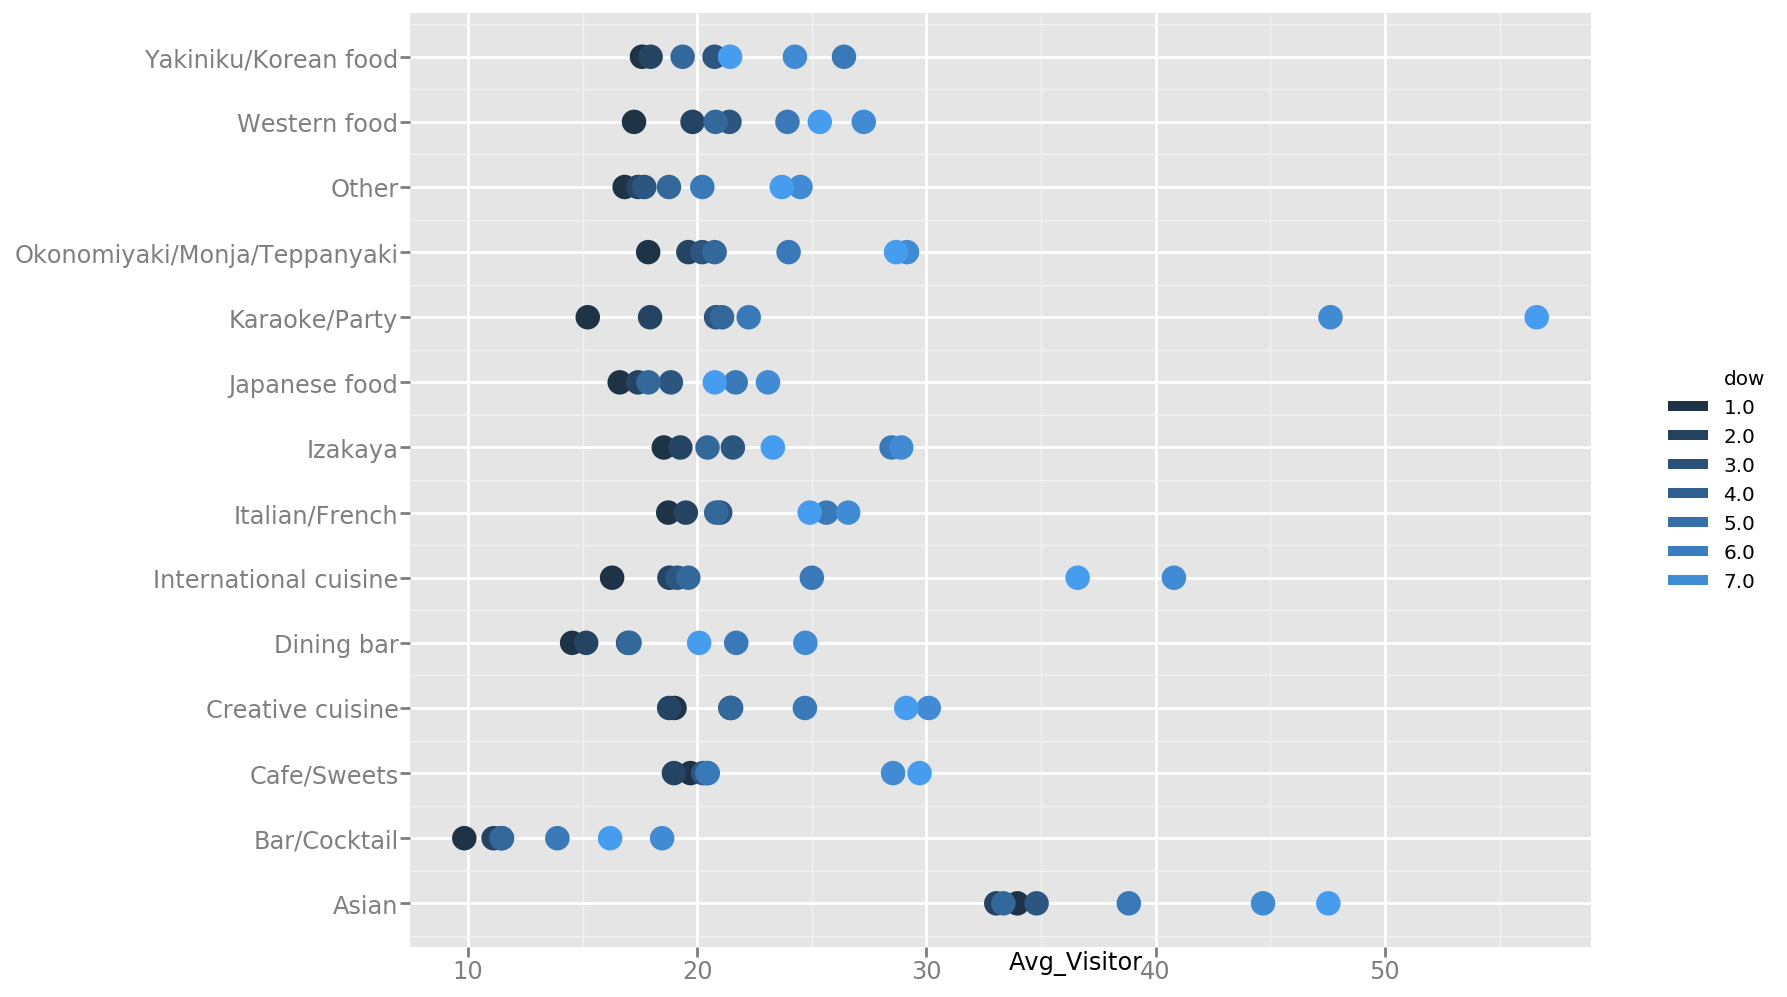

<ggplot: (-9223363283205826521)>

In [42]:
visit_store = pd.merge(air_store, air_visit, on = 'air_store_id', how = 'left')
p = visit_store.groupby(['dow', 'air_genre_name'])['visitors'].mean()
p = pd.DataFrame(p)
p = p.reset_index()
ggplot(p, aes(x = 'visitors', y = 'air_genre_name', color = 'dow')) + geom_point(size = 150) + xlab('\nAvg_Visitor') + ylab(' ')

### Genre VS visit 

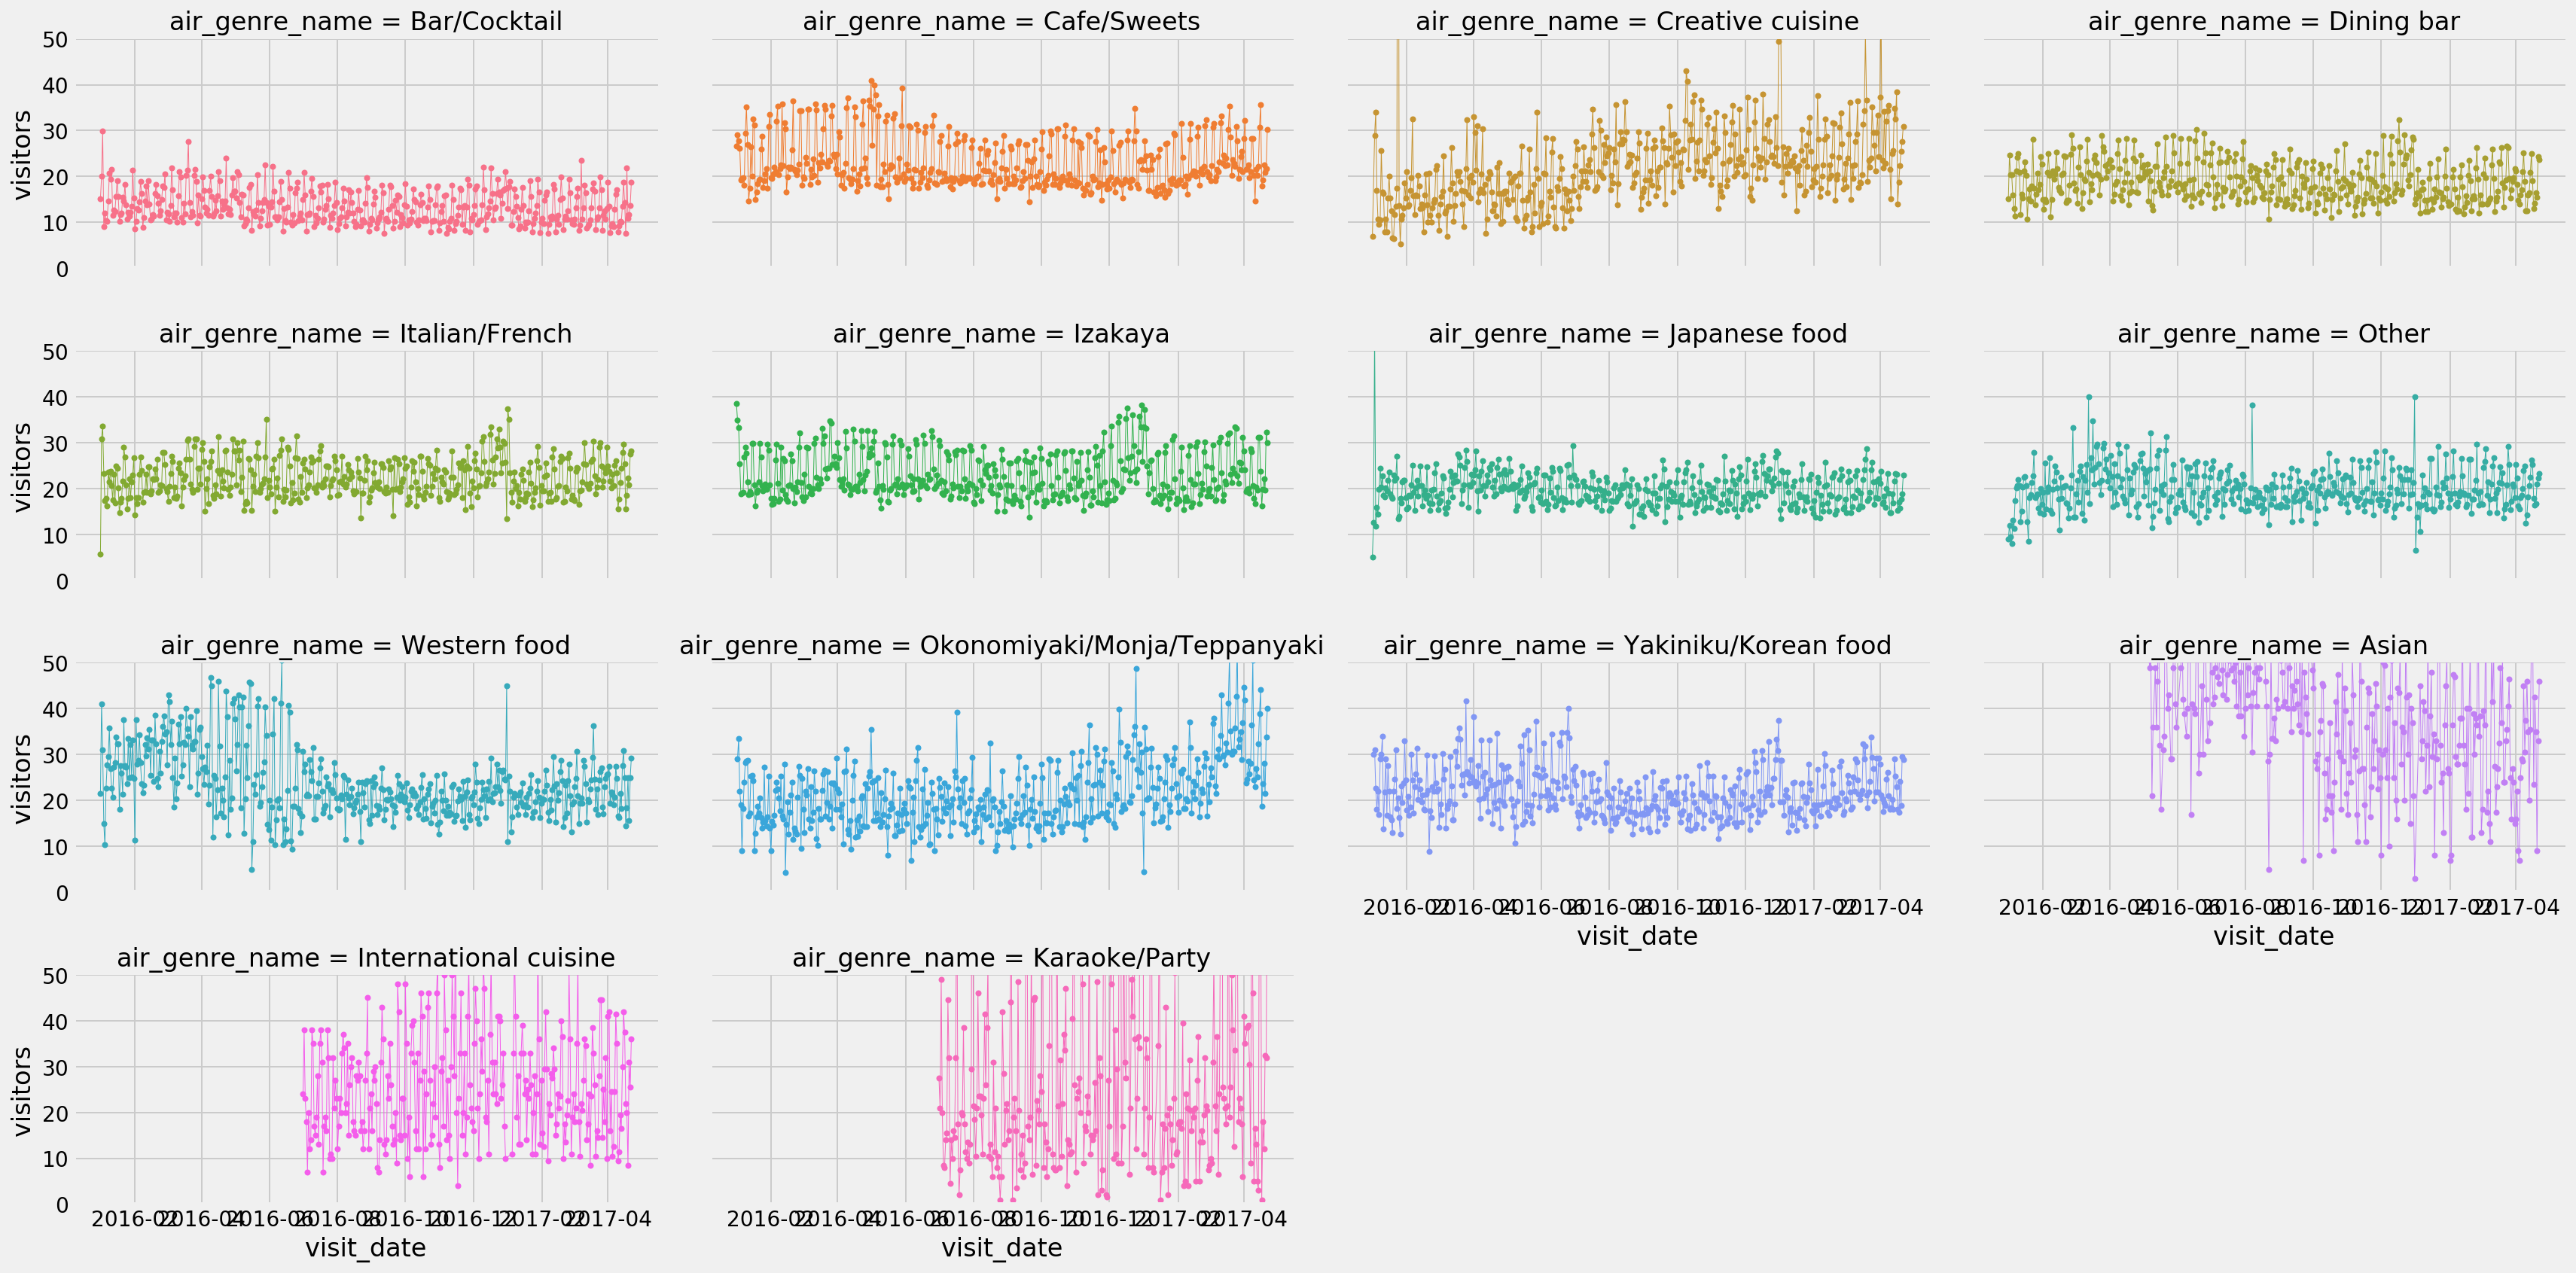

In [44]:
q = visit_store.groupby(['visit_date', 'air_genre_name'])['visitors'].mean()
q = pd.DataFrame(q)
q = q.reset_index()
ax = sns.FacetGrid(q, col="air_genre_name", col_wrap=4, size=3, hue='air_genre_name',margin_titles=True,
                  aspect=2.0, palette='husl', ylim=(0,50))
ax = ax.map(plt.plot, "visit_date", "visitors",  marker=".", linewidth = 0.5)

## Holiday

In [149]:
holidays.calendar_date.max()

Timestamp('2017-05-31 00:00:00')

In [154]:
type(holidays.calendar_date[0])

pandas._libs.tslib.Timestamp

In [153]:
holidays['calendar_date'] = pd.to_datetime(holidays['calendar_date'])

In [151]:
holidays.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


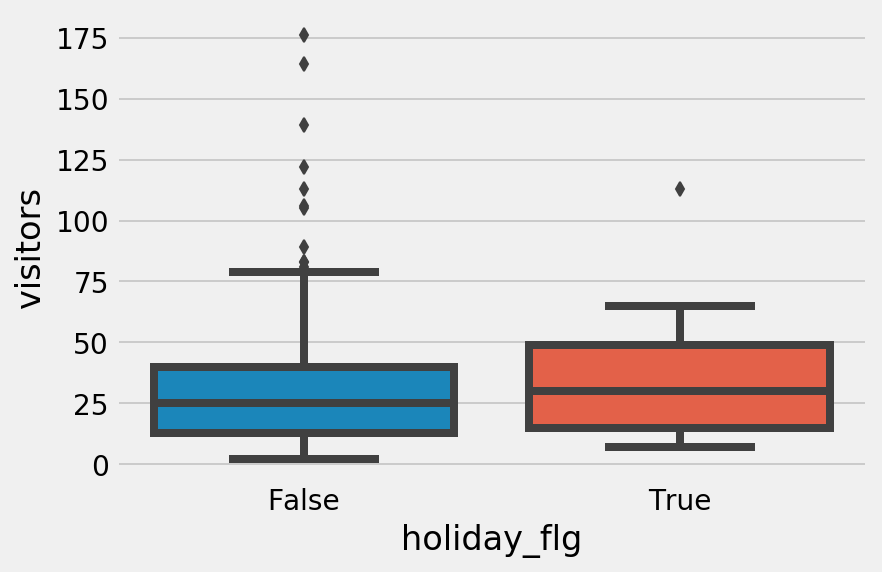

In [47]:
air_reserve['visit_date'] = air_reserve['visit_datetime']
foo = air_reserve.groupby(['air_store_id','visit_date'])['reserve_visitors'].sum()
foo = pd.DataFrame(foo)
foo = foo.reset_index()
all_reserve = pd.merge(foo, air_visit, on = ['air_store_id', 'visit_date'], how = 'inner')
holidays['calendar_date'] = pd.to_datetime(holidays['calendar_date'])
reserve_date = pd.merge(all_reserve, holidays, left_on = 'visit_date', right_on = 'calendar_date', how = 'left')
reserve_date['diff'] = reserve_date['visitors'] - reserve_date['reserve_visitors']
reserve_date.loc[reserve_date['holiday_flg'] == 0, 'holiday_flg'] = False
reserve_date.loc[reserve_date['holiday_flg'] == 1, 'holiday_flg'] = True
ax = sns.boxplot(x = "holiday_flg", y = "visitors", data = reserve_date)

In [78]:
reserve_date.head()

,air_store_id,visit_date,reserve_visitors,visitors,Month,holiday_flg_x,dow,holiday_flg_y,calendar_date,day_of_week,holiday_flg,diff,month,year,week
0,air_0164b9927d20bcc3,2017-01-14,9,25,1,0,6,0,2017-01-14,Saturday,0,16,7,2016,26
1,air_0164b9927d20bcc3,2017-02-18,9,11,2,0,6,0,2017-02-18,Saturday,0,2,7,2016,26
2,air_04341b588bde96cd,2016-11-16,16,28,11,0,3,0,2016-11-16,Wednesday,0,12,7,2016,26
3,air_04cae7c1bc9b2a0b,2016-12-27,16,63,12,0,2,0,2016-12-27,Tuesday,0,47,7,2016,27
4,air_08cb3c4ee6cd6a22,2016-11-11,5,17,11,0,5,0,2016-11-11,Friday,0,12,7,2016,27


In [83]:
reserve_date.drop(['holiday_flg_x','holiday_flg_y', 'calendar_date'], axis = 1, inplace = True)
reserve_date.head()

,air_store_id,visit_date,reserve_visitors,visitors,Month,dow,holiday_flg,diff,month,year,week
0,air_0164b9927d20bcc3,2017-01-14,9,25,1,6,0,16,7,2016,26
1,air_0164b9927d20bcc3,2017-02-18,9,11,2,6,0,2,7,2016,26
2,air_04341b588bde96cd,2016-11-16,16,28,11,3,0,12,7,2016,26
3,air_04cae7c1bc9b2a0b,2016-12-27,16,63,12,2,0,47,7,2016,27
4,air_08cb3c4ee6cd6a22,2016-11-11,5,17,11,5,0,12,7,2016,27


In [87]:
reserve_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 301
Data columns (total 11 columns):
air_store_id        302 non-null object
visit_date          302 non-null datetime64[ns]
reserve_visitors    302 non-null int64
visitors            302 non-null int64
Month               302 non-null int64
dow                 302 non-null int64
holiday_flg         302 non-null object
diff                302 non-null int64
month               302 non-null int64
year                302 non-null int64
week                302 non-null int64
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 38.3+ KB


In [93]:
reserve_date.holiday_flg = reserve_date.holiday_flg.astype(int)

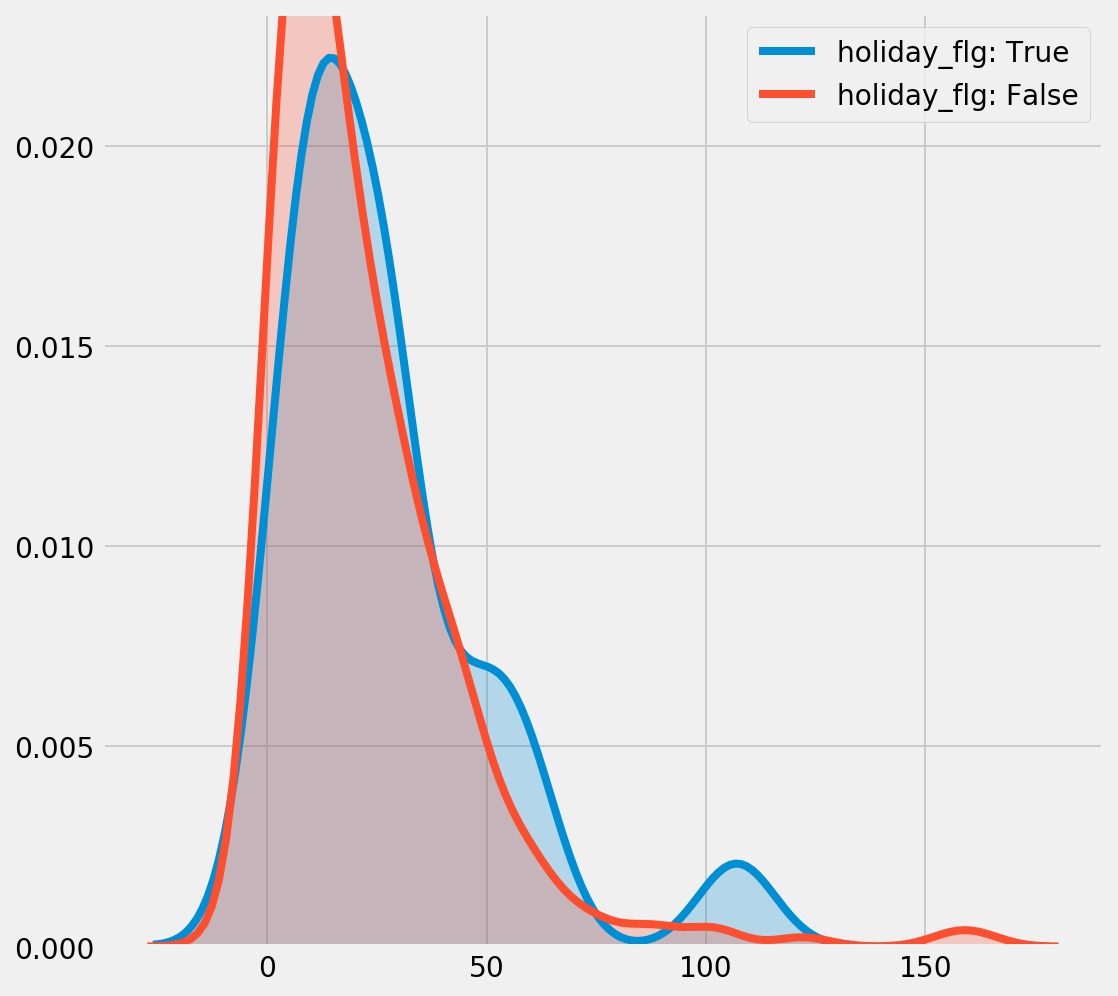

In [48]:
fig = plt.figure(figsize = (8,8))
sns.kdeplot(reserve_date[reserve_date['holiday_flg'] == True]['diff'], label = 'holiday_flg: True', shade = True)
sns.kdeplot(reserve_date[reserve_date['holiday_flg'] == False]['diff'], label = 'holiday_flg: False', shade = True)


In [50]:
g = reserve_date.groupby(['dow', 'holiday_flg'])['visitors'].mean()
g = pd.DataFrame(g)
g = g.reset_index()

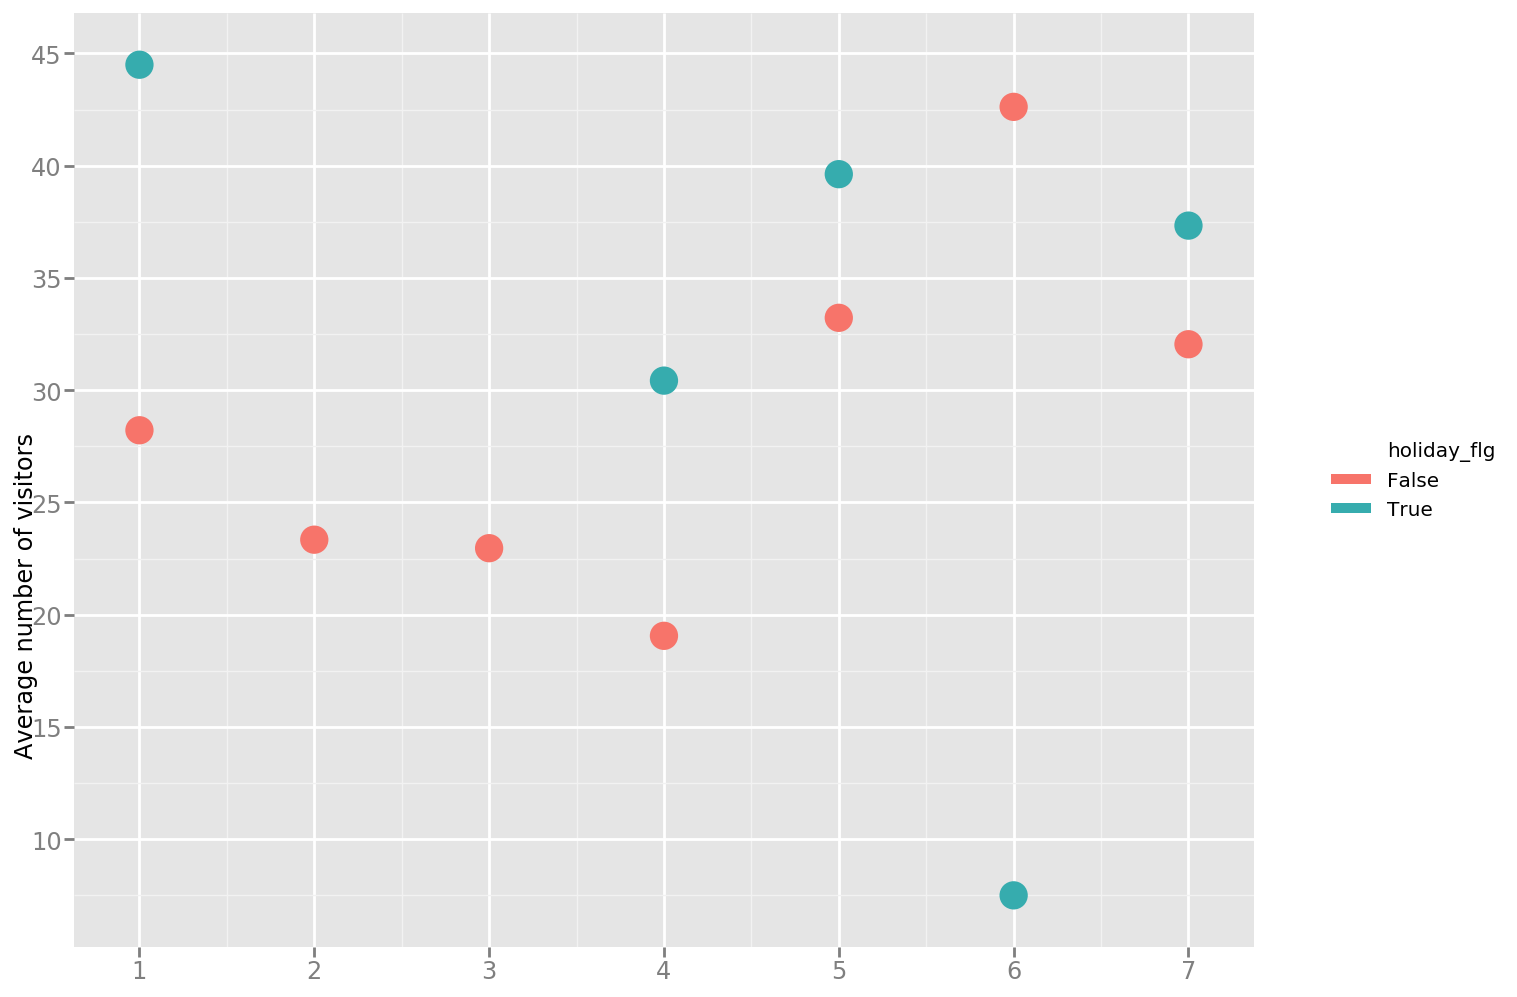

<ggplot: (-9223363283211056787)>

In [52]:
ggplot(g, aes(x = 'dow', y = 'visitors', color = 'holiday_flg')) + geom_point(size = 200) + labs(x = ' ', y = "Average number of visitors")

## Data preparation 

In [115]:
train = reserve_date.copy()
train.drop(['diff','month'], axis = 1, inplace = True);train.head()

,air_store_id,visit_date,reserve_visitors,visitors,Month,dow,holiday_flg,year,week
0,air_0164b9927d20bcc3,2017-01-14,9,25,1,6,0,2016,26
1,air_0164b9927d20bcc3,2017-02-18,9,11,2,6,0,2016,26
2,air_04341b588bde96cd,2016-11-16,16,28,11,3,0,2016,26
3,air_04cae7c1bc9b2a0b,2016-12-27,16,63,12,2,0,2016,27
4,air_08cb3c4ee6cd6a22,2016-11-11,5,17,11,5,0,2016,27


In [188]:
test = pd.read_csv("sample_submission.csv")

In [189]:
test['air_store_id'] = test['id'].map(lambda x: '_'.join(x.split('_')[:2]))
test['visit_date'] = test['id'].map(lambda x: str(x).split('_')[2])
test['visit_date'] = pd.to_datetime(test['visit_date'])
test['Month'] = test['visit_date'].dt.month
test['dow'] = test['visit_date'].dt.dayofweek
test['year'] = test['visit_date'].dt.year
test['week'] = test['visit_date'].dt.week
#test['visit_date'] = test['visit_date'].dt.date

In [190]:
holidays['calendar_date'] = pd.to_datetime(holidays['calendar_date'])
test = pd.merge(test, holidays, left_on = 'visit_date', right_on = 'calendar_date', how = 'left')

In [191]:
test = pd.merge(test, air_reserve, how='left', on=['air_store_id','visit_date'])
test.drop(['calendar_date', 'day_of_week','id'], axis = 1, inplace = True)

In [192]:
test = test.fillna(-1)

In [194]:
test = test[['air_store_id','visit_date','reserve_visitors','visitors','Month','dow','holiday_flg','year','week']]

In [199]:
test.head()

,air_store_id,visit_date,reserve_visitors,visitors,Month,dow,holiday_flg,year,week
0,air_00a91d42b08b08d9,2017-04-23,-1.0,0,4,6,0,2017,16
1,air_00a91d42b08b08d9,2017-04-24,-1.0,0,4,0,0,2017,17
2,air_00a91d42b08b08d9,2017-04-25,-1.0,0,4,1,0,2017,17
3,air_00a91d42b08b08d9,2017-04-26,-1.0,0,4,2,0,2017,17
4,air_00a91d42b08b08d9,2017-04-27,-1.0,0,4,3,0,2017,17


# Forecasting Method

## Time series - Arima

In [251]:
period = len(set(test.visit_date.unique()))
valid_pd = air_visit.visit_date.max()- timedelta(period); valid_pd
start_date = air_visit.visit_date.min()
end_date = air_visit.visit_date.max()

take one air store as an example to check the accuracy of the ARIMA

In [252]:
ts_all = air_visit_idx.loc[:,'visitors']
ts_id = 'air_ba937bf13d40fb24'
ts = ts_all[ts_id];ts.head()

visit_date
2016-01-13    25
2016-01-14    32
2016-01-15    29
2016-01-16    22
2016-01-18     6
Name: visitors, dtype: int64

convert int to float for ts, otherwise there will be an error

In [253]:
ts = ts.astype(float)

set frequency for date index, otherwise there will be an error

In [254]:
ts = ts.asfreq(freq='1d')

In [255]:
print(ts.index.freq)

<Day>


try different value for p, d, q to select the best model.

In [268]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
#warnings.filterwarnings("ignore") # specify to ignore warning messages

best_score, best_pdq, best_seasonal = float("inf"), None, None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < best_score:
                best_score, best_pdq, best_seasonal = results.aic, param,param_seasonal
                

        except:
            continue
print('ARIMA{}x{}12 - AIC:{}'.format(best_pdq, best_seasonal, best_score))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1120.397123615513


In [269]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000    102.757     -0.010      0.992    -202.399     200.399
ma.S.L12      -1.0000    430.933     -0.002      0.998    -845.614     843.614
sigma2        12.4809   5631.734      0.002      0.998    -1.1e+04    1.11e+04


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning:

invalid value encountered in less_equal



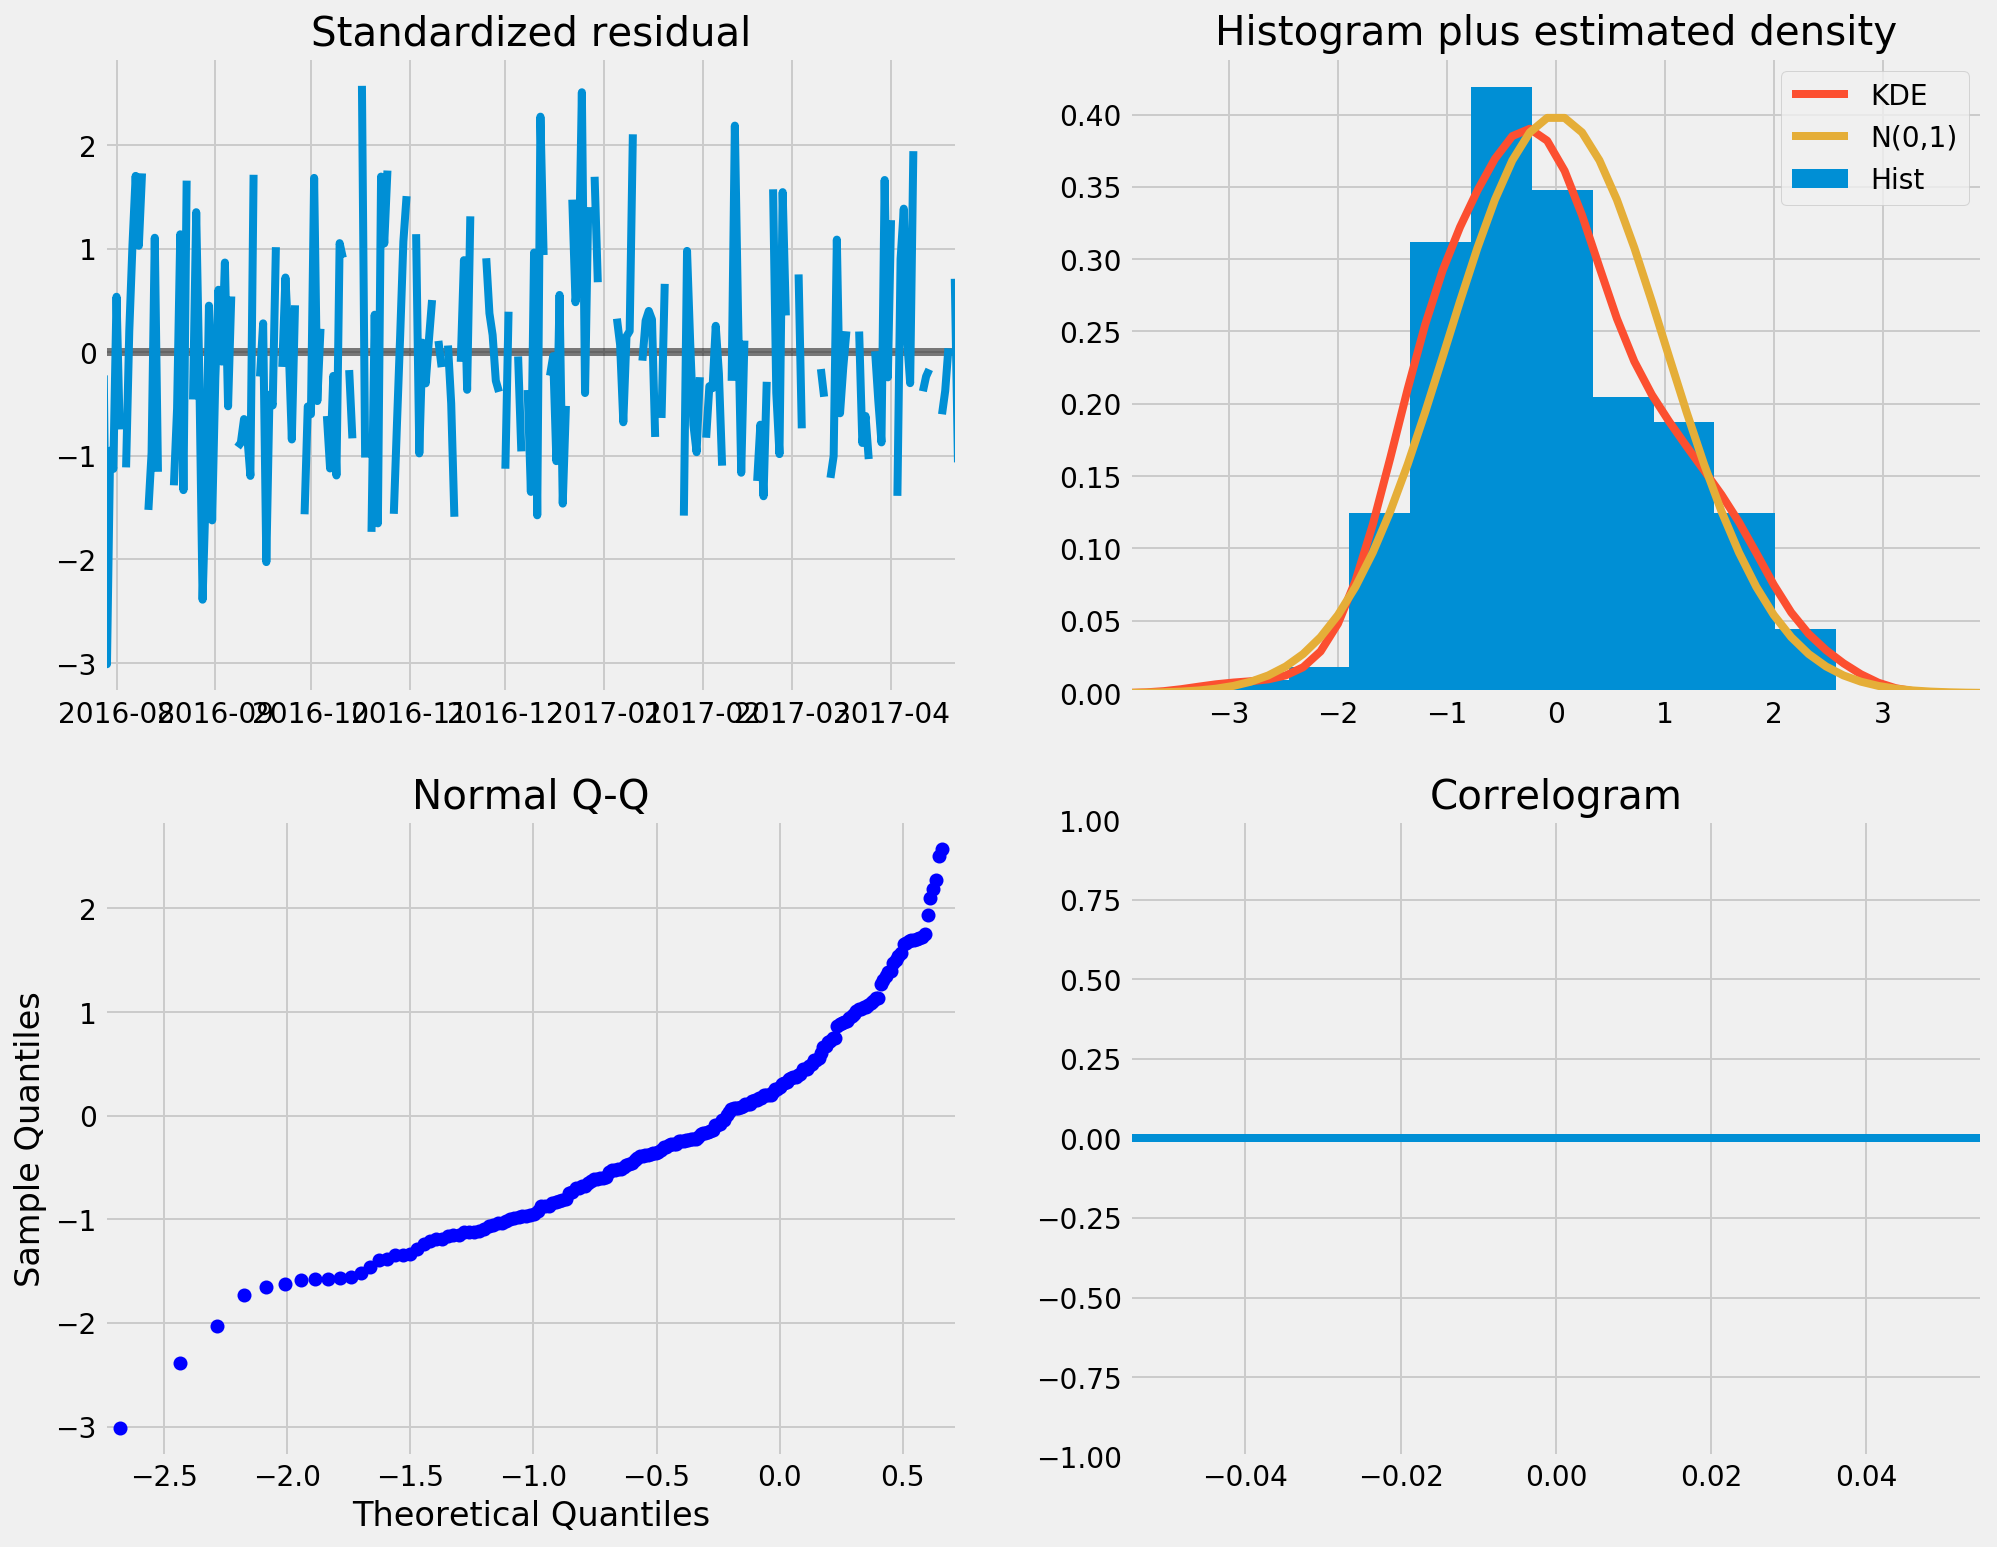

In [270]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Use same period to valid the prediction inside the sample.

In [271]:
pred = results.get_prediction(start=valid_pd, dynamic=False)
pred_ci = pred.conf_int()

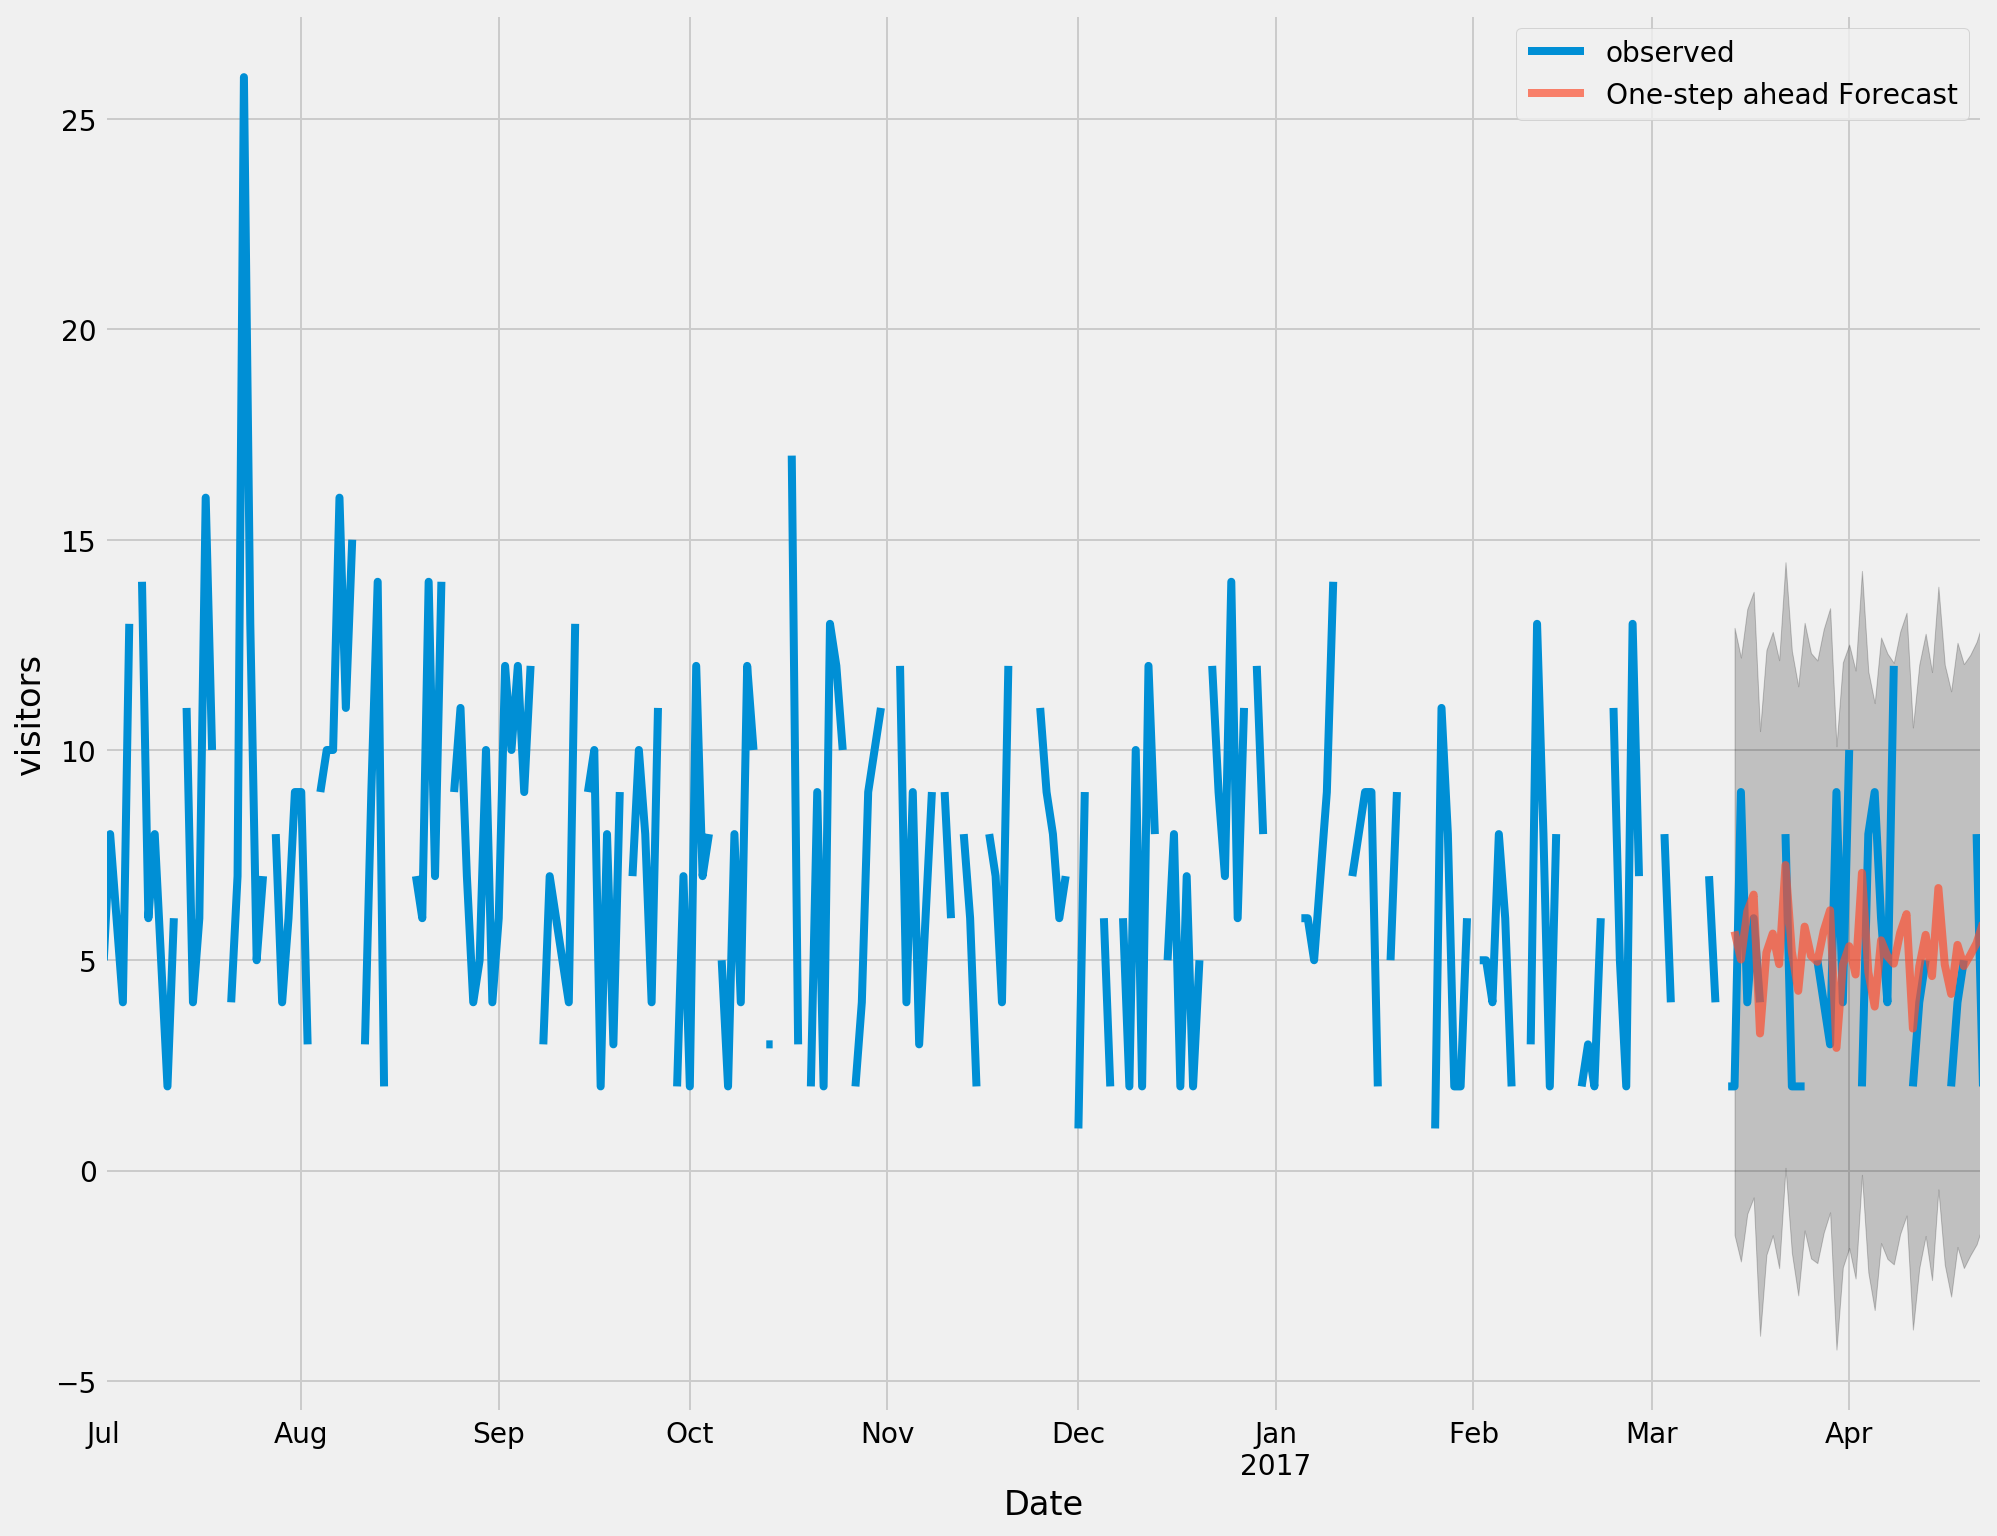

In [272]:
fig,ax = plt.subplots(figsize = (15, 12))
ax = ts[start_date:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('visitors')
plt.legend()

plt.show()

In [273]:
ts_forecasted = pred.predicted_mean
ts_truth = ts[valid_pd:]

# Compute the mean square error
mse = ((ts_forecasted - ts_truth) ** 2).mean()

rmse = math.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 3.08


In [245]:
import math

predict visitors in the future

In [66]:
pred_uc = results.get_forecast(steps=period)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
a = pred_uc.predicted_mean

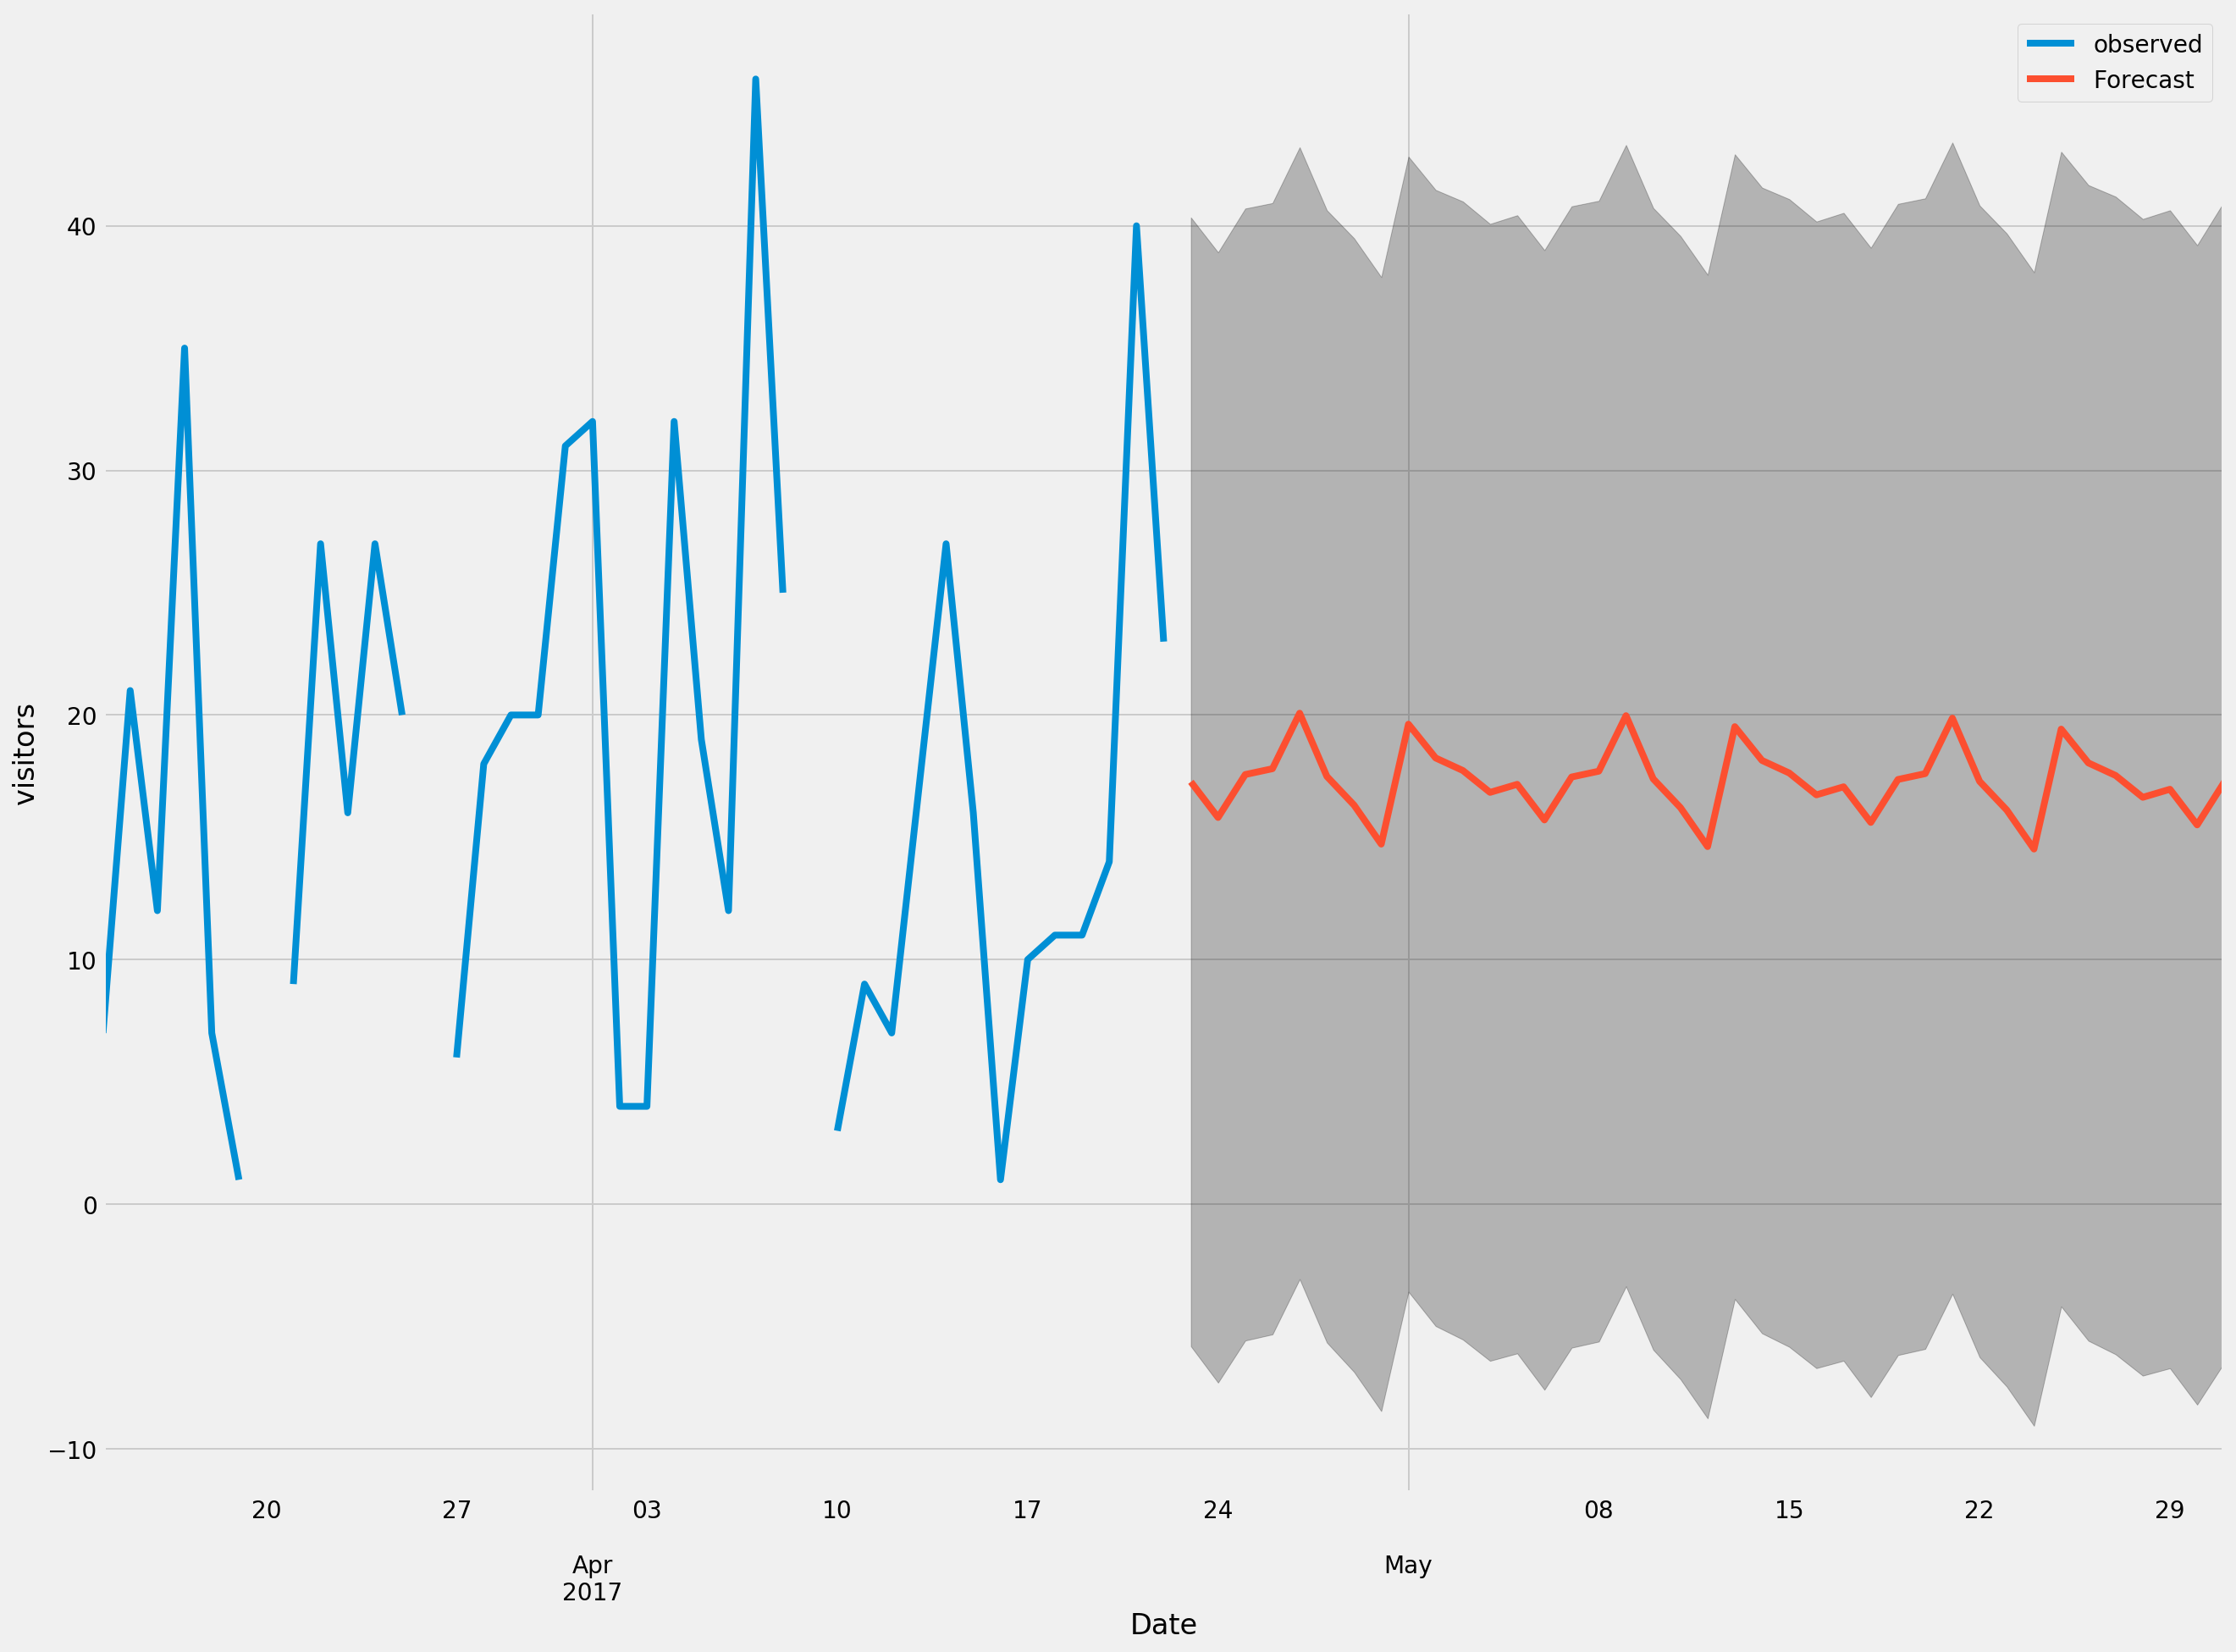

In [67]:
ax = ts[valid_pd:].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('visitors')

plt.legend()
plt.show()

In [262]:
def visitor_forecast(ts):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    best_score, best_pdq, best_seasonal = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                if results.aic < best_score:
                    best_score, best_pdq, best_seasonal = results.aic, param,param_seasonal
            except:
                continue
    mod = sm.tsa.statespace.SARIMAX(ts,
                                order=best_pdq,
                                seasonal_order=best_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    pred_uc = results.get_forecast(steps=period)
    pred_ci = pred_uc.conf_int()
    pred = pred_uc.predicted_mean
    return pred, best_score


In [263]:
store_id = set(air_visit_idx.index.get_level_values('air_store_id').unique())

In [ ]:
df = pd.DataFrame([])
for i in store_id:
    ts = ts_all[i]
    ts = ts.asfreq(freq='1d')
    ts = ts.astype(float)
    df = df.append(pd.DataFrame({'air_id':i, 'visitor': visitor_forecast(ts)}), ignore_index=True)
df.head()   

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/sit

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/sit

Even though the result doesn't seems satisfied, we can still use this model as a reference. Now make above steps a function to apply for each store.

In [202]:
col = [c for c in reserve_date if c not in ['id', 'air_store_id', 'visit_date','visitors','diff']];col

['reserve_visitors', 'Month', 'dow', 'holiday_flg', 'year', 'week']

## XGBoost Method

In [213]:
from sklearn import *

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20



In [204]:
model1 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=330, subsample=0.8, 
                      colsample_bytree=0.8, max_depth=10)

In [208]:
model1.fit(train[col], train['visitors'].values)
print("Model1 trained")

Model1 trained


In [209]:
valid1 = model1.predict(train[col])

In [214]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

In [216]:
actual_output = train['visitors'].values
print('RMSE: ', RMSLE(actual_output, valid1))

RMSE:  0.997787831932


In [217]:
preds1 = model1.predict(test[col])

## Gradient Boosting

In [105]:
model2 = GradientBoostingClassifier(learning_rate=0.2, random_state=3,
                    n_estimators=180, subsample=0.78, max_depth=10)

In [107]:
model2.fit(reserve_date[col], reserve_date['visitors'].values)
print("Model2 trained")

Model2 trained


In [219]:
valid2 = model2.predict(train[col])
actual_output = train['visitors'].values
print('RMSE: ', RMSLE(actual_output, valid2))

RMSE:  18.9334841271


In [207]:
preds2 = model2.predict(test[col])

# Merge result

In [225]:
merge = test[['air_store_id','visit_date']].copy()
merge['preds1'] = pd.Series(preds1)
merge['preds2'] = pd.Series(preds2)
merge['preds3'] = pd.Series(preds3)
merge.head()

,air_store_id,visit_date,preds1,preds2
0,air_00a91d42b08b08d9,2017-04-23,32.990681,30
1,air_00a91d42b08b08d9,2017-04-24,19.369766,17
2,air_00a91d42b08b08d9,2017-04-25,19.369766,17
3,air_00a91d42b08b08d9,2017-04-26,22.022285,17
4,air_00a91d42b08b08d9,2017-04-27,21.874001,17
